<a href="https://colab.research.google.com/github/VedKate/Vedeneeva_Ekaterina_RT5/blob/main/BMSTU_TMO_2022/%D0%A0%D0%9A2_%D0%92%D0%B5%D0%B4%D0%B5%D0%BD%D0%B5%D0%B5%D0%B2%D0%B0_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# РК-2
# Веденеева Е.И. РТ5-61Б

В качестве датасета будем использовать "игрушечный" датасет про вино ([wine](https://scikit-learn.org/stable/datasets/toy_dataset.html))из sklearn. 

Alcohol

Malic acid

Ash

Alcalinity of ash

Magnesium

Total phenols

Flavanoids

Nonflavanoid phenols

Proanthocyanins

Color intensity

Hue

OD280/OD315 of diluted wines

Proline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets, preprocessing
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,  balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler


%matplotlib inline 
sns.set(style="ticks")

In [3]:

# Загрузка датасета
wine = datasets.load_wine(as_frame=True)
df : pd.DataFrame = wine.frame

**Основные харакеристики**

Размер набора данных

In [5]:
df.shape

(178, 14)

Типы колонок

In [6]:
df.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object

Проверяем наличие пропусков

In [7]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

Пропусков нет

In [8]:
df.head(100)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
96,11.81,2.12,2.74,21.5,134.0,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625.0,1
97,12.29,1.41,1.98,16.0,85.0,2.55,2.50,0.29,1.77,2.90,1.23,2.74,428.0,1
98,12.37,1.07,2.10,18.5,88.0,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660.0,1


**Корреляционная матрица** (больше для наглядности)

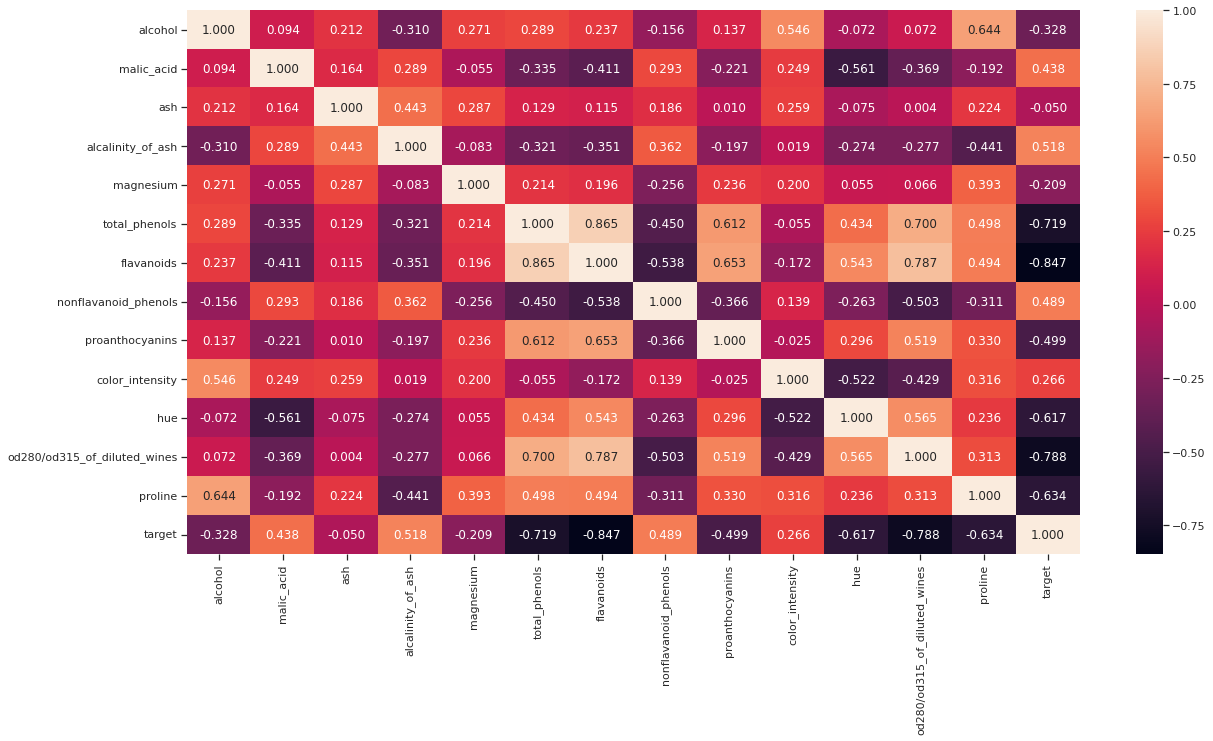

In [9]:
ig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(method='pearson'), ax=ax, annot=True, fmt='.3f')

Наблюдается довольно сильная корреляция между некоторыми нецелевыми признаками. Это может повлиять на результаты использования моделей. На градиентный бустинг в меньшей степени.

In [23]:
# Копия датасета для визуализации
d_to_viz = df.copy()
d_to_viz['target'] = d_to_viz['target'].\
 map({i : wine.target_names[i] for i in range(0, len(wine.target_names))})
d_to_viz.sample(5, random_state=1)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
161,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.88,0.96,1.82,680.0,class_2
117,12.42,1.61,2.19,22.5,108.0,2.00,2.09,0.34,1.61,2.06,1.06,2.96,345.0,class_1
19,13.64,3.10,2.56,15.2,116.0,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845.0,class_0
69,12.21,1.19,1.75,16.8,151.0,1.85,1.28,0.14,2.50,2.85,1.28,3.07,718.0,class_1
53,13.77,1.90,2.68,17.1,115.0,3.00,2.79,0.39,1.68,6.30,1.13,2.93,1375.0,class_0


In [10]:
df.target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

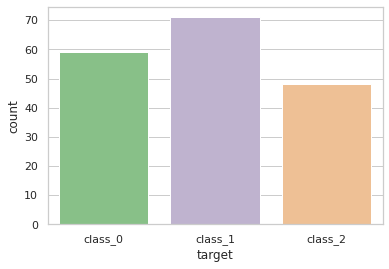

In [24]:
# График распределения классов
with sns.axes_style('whitegrid'):
 sns.countplot(x='target', data=d_to_viz, palette='Accent')
 plt.show()


Задача классификации с тремя классами, приблизительно равномерно распределенными.

**Обучение моделей**

**метрики**

Для получения обобщенной эффективности используем кросс-валидацию. 
Используем метрики balanced_accuracy И f1.

Делим данные на контролную и обучающую выборки

In [11]:
X = df.drop(columns=['target'])
y = df['target']
# разделим данные с помощью Scikit-Learn's train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

**Градиентный бустинг**

In [45]:
model = XGBClassifier(eval_metric='mlogloss')
#метрики

f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted').mean()
recall_weighted = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_weighted').mean()
balanced_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
print('f1_weighted: '+ str(round(f1,2)) + ' balanced_accuracy ' + str(round(balanced_accuracy,2)) + ' recall_weighted ' + str(round(recall_weighted,2)))

f1_weighted: 0.94 balanced_accuracy 0.94 recall_weighted 0.94


**k-NN**

In [46]:
from sklearn.neighbors import KNeighborsClassifier
logreg = KNeighborsClassifier(n_neighbors=6)

# метрики
f1 = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1_weighted').mean()
recall_weighted = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall_weighted').mean()
balanced_accuracy = cross_val_score(logreg, X_train, y_train, cv=5, scoring='balanced_accuracy').mean()
print('f1_weighted: '+ str(round(f1,2)) + ' balanced_accuracy ' + str(round(balanced_accuracy,2)) + ' recall_weighted ' + str(round(recall_weighted,2)))




f1_weighted: 0.69 balanced_accuracy 0.69 recall_weighted 0.7


Видно, что k-NN показывает себя хуже, чем градиентный бустинг, как более протсая и менне наежная модель.

**Проверка на контрольной выборке**

**Градиентный бустинг**

In [18]:
model.fit(X_train, y_train)
XGB_res = model.predict(X_test)
bascore = balanced_accuracy_score(y_test, XGB_res)
f1 = f1_score(y_test, XGB_res, average='weighted')
print('f1_weighted: '+ str(round(f1,2)) + ' balanced_accuracy ' + str(round(bascore,2)))

f1_weighted: 0.91 balanced_accuracy 0.92


**k-NN**

In [49]:
logreg.fit(X_train, y_train)
knn_res = logreg.predict(X_test)
bascore = balanced_accuracy_score(y_test, knn_res)
f1 = f1_score(y_test, knn_res, average='weighted')
print('f1_weighted: '+ str(round(f1,2)) + ' balanced_accuracy ' + str(round(bascore,2)))

f1_weighted: 0.79 balanced_accuracy 0.76


**Матрица ошибок**

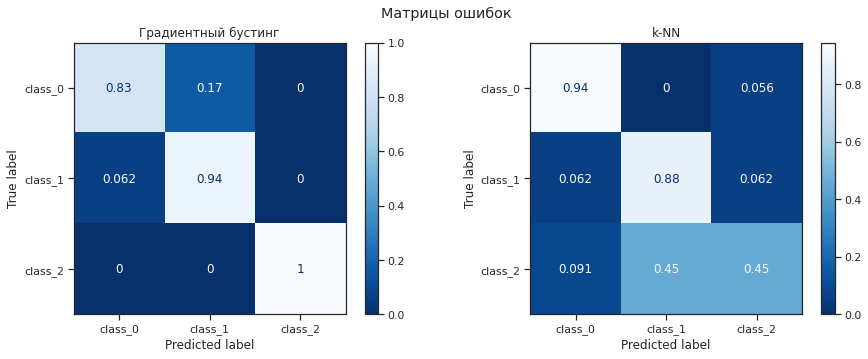

In [36]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(y_test, XGB_res, display_labels=wine.target_names,normalize='true', ax=ax[0], cmap='Blues_r')
ConfusionMatrixDisplay.from_predictions(y_test, knn_res, display_labels=wine.target_names,normalize='true', ax=ax[1], cmap='Blues_r')

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('Градиентный бустинг')
ax[1].title.set_text('k-NN')

plt.show()


Метрики, а так же матрица ошибок показывают, то градиентный бустинг является более предпочтительной моделью для данного датасета. 